# import library

In [1]:
# import all library
import librosa, IPython, datetime, time, os, sys, copy, dill, pickle, mir_eval, glob
import numpy as np
import pandas as pd
#from scipy.spatial.distance import euclidean, pdist, squareform
#import IPython.display as ipd
#from datetime import datetime
from time import gmtime, strftime
#from imageio import imread as imread
#from imageio import imsave as imsave
#import librosa.display
import tensorflow as tf
#from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
#from midiutil.MidiFile import MIDIFile
#import ray
from ops import *
#import pydub
#from ADTLib import ADT
import matplotlib.pyplot as plt
%matplotlib inline

print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))
print ("[info] Python Version:   " + sys.version.split('\n')[0].split(' ')[0])
print ("[info] Working Dir:      " + os.getcwd()+'/')

# enable gpu usage constraint here
fixed_gpu_usage = 1
selected_gpu_id = 0

# if gpu usage is constraint, limit certain gpu for use
if (fixed_gpu_usage == 1):
    # set available GPU
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"        # list GPU sequence by PCI bus GPU ID
    #os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"         # 0 for GPU 0(1080Ti), 1 for GPU 1(1080Ti), 2 for GPU 2(2080Ti)
    os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(selected_gpu_id)   # 0 for GPU 0(1080Ti), 1 for GPU 1(1080Ti), 2 for GPU 2(2080Ti)

    # check available GPU
    from tensorflow.python.client import device_lib
    for x in range(1, len(device_lib.list_local_devices())):
        print ("[info] GPU " + device_lib.list_local_devices()[x].physical_device_desc)

[info] Current Time:     2019/03/19  04:15:39
[info] Python Version:   3.6.5
[info] Working Dir:      /host/home/python/musegan_npz/
[info] GPU device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


# Define SSM data batch reader for testing

In [2]:
test_file_names_list = np.sort(glob.glob('./generation_evaluation_dir/merged_ssm_pkg/*.pkl', recursive=True)).tolist()
print ('[info] Total test files: {}'.format(len(test_file_names_list)))

total_test_files_num = len(test_file_names_list)   

def get_batch_ssm_data(get_batch_num=total_test_files_num):

    batch_file_names_list = copy.deepcopy([test_file_names_list[x] for x in list(range(0, total_test_files_num))])
        
    # loop over batch file names
    
    cqt_ssm_batch_list = []
    drum_ssm_batch_list = []
    #drum_ssm_mask_list = []
    #valid_pix_mean_list = []
    song_bars_len_list = []    
    
    for file_name_read in batch_file_names_list:
        
        with open(file_name_read, 'rb') as pkl_file:        
            reload_data_package = pickle.load(pkl_file)
            
        cqt_ssm_data = reload_data_package[0].astype(np.float32)
        drum_ssm_data = reload_data_package[1].astype(np.float32)
        #drum_ssm_mask = reload_data_package[2].astype(np.float32)
        #valid_pix_mean = reload_data_package[3].astype(np.float32)                
        song_bars_len = reload_data_package[4]
        
        # save data into list
        cqt_ssm_batch_list.append(cqt_ssm_data)
        drum_ssm_batch_list.append(drum_ssm_data)
        #drum_ssm_mask_list.append(drum_ssm_mask)
        #valid_pix_mean_list.append(valid_pix_mean)
        song_bars_len_list.append(song_bars_len)
    
    # merge batch data
    ssm_batch_output = [cqt_ssm_batch_list, 
                        drum_ssm_batch_list, 
                        #drum_ssm_mask_list, 
                        song_bars_len_list,
                        #valid_pix_mean_list
                       ]
    
    return(ssm_batch_output)

print ('[info] Data loader define done.')


print('')
#print ('[info] CQT SSM shape: {}'.format(get_batch_ssm_data(get_batch_num=16, traing_phase=0)[0][0].shape))
#print ('[info] Drum SSM shape: {}'.format(get_batch_ssm_data(get_batch_num=16, traing_phase=0)[1][0].shape))
#print ('[info] Drum SSM mask shape: {}'.format(get_batch_ssm_data(get_batch_num=16, traing_phase=0)[2][0].shape))
#print ('[info] Song bars len shape: {}'.format(get_batch_ssm_data(get_batch_num=16, traing_phase=0)[3][0].shape))
#print ('[info] SSM valid pix shape: {}'.format(get_batch_ssm_data(get_batch_num=16, traing_phase=0)[4][0].shape))

picked_song_idx = 20
print ('[info] CQT SSM shape: {}'.format(get_batch_ssm_data()[0][picked_song_idx].shape))
print ('[info] Drum SSM shape: {}'.format(get_batch_ssm_data()[1][picked_song_idx].shape))
print ('[info] Song bars len shape: {}'.format(get_batch_ssm_data()[2][picked_song_idx]))

# get CQT SSM shape
cqt_ssm_shape = get_batch_ssm_data()[0][0].shape

[info] Total test files: 24
[info] Data loader define done.

[info] CQT SSM shape: (256, 256, 3)
[info] Drum SSM shape: (256, 256, 3)
[info] Song bars len shape: 141


# Define tensoeflow mode here

# Define tensorflow placeholder

In [3]:
# input for drum_arranger, (batch size, 256, 256, 3)
cqt_ssm_ph = tf.placeholder(tf.float32, shape=[None, 
                                               cqt_ssm_shape[0], 
                                               cqt_ssm_shape[1], 
                                               cqt_ssm_shape[2]])

#drum_ssm_ph = tf.placeholder(tf.float32, shape=[None, 
#                                                drum_ssm_shape[0], 
#                                                drum_ssm_shape[1], 
#                                                drum_ssm_shape[2]])

#ssm_mask_ph = tf.placeholder(tf.float32, shape=[None, 
#                                                ssm_mask_shape[0], 
#                                                ssm_mask_shape[1], 
#                                                ssm_mask_shape[2]])

#pix_mean_ph = tf.placeholder(tf.float32, shape=[None, 1])

# Re-Define NN Model for test

In [4]:
# define drum_arranger
def ssm_arranger(sarr_cqt_ssm_input,                 # input data shape = (batch_num, 256, 256, 3)
                 reuse=False):
                
    with tf.variable_scope('sarr', reuse=reuse):
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
        
        # set basic parameters
        fmap_layer = 48
        #keep_prob = 0.8
        unet_output_c_dim = 1
        
        e0 = sarr_cqt_ssm_input
            
        # image is (256 x 256 x input_c_dim)
        e1 = tf.nn.elu(instance_norm(conv2d(e0, fmap_layer*1, name='g_e1_conv'), 'g_bn_e1'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = tf.nn.elu(instance_norm(conv2d(e1, fmap_layer*2, name='g_e2_conv'), 'g_bn_e2'))
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = tf.nn.elu(instance_norm(conv2d(e2, fmap_layer*4, name='g_e3_conv'), 'g_bn_e3'))
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = tf.nn.elu(instance_norm(conv2d(e3, fmap_layer*4, name='g_e4_conv'), 'g_bn_e4'))
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = tf.nn.elu(instance_norm(conv2d(e4, fmap_layer*4, name='g_e5_conv'), 'g_bn_e5'))
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = tf.nn.elu(instance_norm(conv2d(e5, fmap_layer*4, name='g_e6_conv'), 'g_bn_e6'))
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = tf.nn.elu(instance_norm(conv2d(e6, fmap_layer*4, name='g_e7_conv'), 'g_bn_e7'))
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = tf.nn.elu(instance_norm(conv2d(e7, fmap_layer*4, name='g_e8_conv'), 'g_bn_e8'))
        # e8 is (1 x 1 x self.gf_dim*8)

        d1 = tf.nn.elu(instance_norm(deconv2d(e8, fmap_layer*4, name='g_d1'), 'g_bn_d1'))
        #d1 = tf.nn.dropout(d1, keep_prob)
        d1 = tf.concat([d1, e7*0.2], axis=3)
        # d1 is (2 x 2 x self.gf_dim*8*2)

        d2 = tf.nn.elu(instance_norm(deconv2d(d1, fmap_layer*4, name='g_d2'), 'g_bn_d2'))
        #d2 = tf.nn.dropout(d2, keep_prob)
        d2 = tf.concat([d2, e6*0.20], axis=3)
        # d2 is (4 x 4 x self.gf_dim*8*2)

        d3 = tf.nn.elu(instance_norm(deconv2d(d2, fmap_layer*4, name='g_d3'), 'g_bn_d3'))
        #d3 = tf.nn.dropout(d3, keep_prob)
        d3 = tf.concat([d3, e5*0.20], axis=3)
        # d3 is (8 x 8 x self.gf_dim*8*2)

        d4 = tf.nn.elu(instance_norm(deconv2d(d3, fmap_layer*4, name='g_d4'), 'g_bn_d4'))
        d4 = tf.concat([d4, e4*0.20], axis=3)
        # d4 is (16 x 16 x self.gf_dim*8*2)

        d5 = tf.nn.elu(instance_norm(deconv2d(d4, fmap_layer*4, name='g_d5'), 'g_bn_d5'))
        d5 = tf.concat([d5, e3*0.10], axis=3)
        # d5 is (32 x 32 x self.gf_dim*4*2)

        d6 = tf.nn.elu(instance_norm(deconv2d(d5, fmap_layer*2, name='g_d6'), 'g_bn_d6'))
        d6 = tf.concat([d6, e2*0.05], axis=3)
        # d6 is (64 x 64 x self.gf_dim*2*2)

        d7 = tf.nn.elu(instance_norm(deconv2d(d6, fmap_layer*2, name='g_d7'), 'g_bn_d7'))
        d7 = tf.concat([d7, e1*0.025], axis=3)
        # d7 is (128 x 128 x self.gf_dim*1*2)

        #d8 = deconv2d(tf.nn.elu(d7), unet_output_c_dim, name='g_d8')
        d8 = deconv2d(d7, unet_output_c_dim, name='g_d8')
        # d8 is (256 x 256 x output_c_dim)
        
        # finally get output
        #sarr_output = tf.nn.tanh(d8) * 200
        sarr_output = d8
        
        return (sarr_output)
    
print ('Model define done.')

Model define done.


# Define diff value caulculation function

In [5]:
## input tensor must be 4-D data
#def get_matx_3_layer_tf(matx_data_in):
#    
#    matx_layer_0 = matx_data_in
#    
#    matx_data_pady = tf.pad(matx_data_in,
#                            paddings=[[0,0], [0,0], [1,0], [0,0]],
#                            mode='CONSTANT',
#                            name='tf_padx',
#                            constant_values=0
#                            )[:, :, :-1, :]
#                            #)[:, :matx_data_in.get_shape()[1], :, :]
#        
#    matx_layer_1 = matx_data_in - matx_data_pady
#    
#    matx_data_padx = tf.pad(matx_data_in,
#                            paddings=[[0,0], [1,0], [0,0], [0,0]],
#                            mode='CONSTANT',
#                            name='tf_pady',
#                            constant_values=0
#                            )[:, :-1, :, :]
#                            #)[:, :, :matx_data_in.get_shape()[2], :]    
#    
#    matx_layer_2 = matx_data_in - matx_data_padx
#    
#    matx_layer_all = tf.concat([matx_layer_0, matx_layer_1, matx_layer_2], 
#                               axis=-1,
#                               name='tf_layer_concat')
#    
#    return matx_layer_all    
#    
#print ('Diff function define done.')

# Define loss function

In [6]:
## soft range error
#def loss_func3(logits_in, 
#               labels_in, 
#               ssm_mask_in, 
#               ssm_mask_pxavg_in):
#    
#    #tf_abs_error = tf.abs(logits_in - labels_in)
#    
#    # only use ssm shape data
#    tf_abs_error = tf.multiply(tf.abs(logits_in - labels_in), ssm_mask_in)
#    
#    # set soft range loss
#    #soft_loss_range = 2.0
#    soft_loss_range = (1.0 * 1.0) / 100.0
#    tf_soft_abs_error = tf.where(tf_abs_error <= soft_loss_range * tf.ones_like(tf_abs_error),
#                                 tf.zeros_like(tf_abs_error),
#                                 tf_abs_error - soft_loss_range * tf.ones_like(tf_abs_error)
#                                 )
#    
#    #single_value_error = tf.reduce_mean(tf_soft_abs_error) / ssm_mask_pxavg_in
#    #single_value_error = tf.reduce_mean(tf.div(tf_soft_abs_error, ssm_mask_pxavg_in))
#    single_value_error = tf.div(tf.reduce_mean(tf_soft_abs_error), ssm_mask_pxavg_in)
#    
#    return (single_value_error * 100.0)

#print ('Loss function define done.')

# Connect model here

In [7]:
# connect model data-flow
sarr_output_data = ssm_arranger(cqt_ssm_ph, reuse=False)

#sarr_output_data_all_layer = get_matx_3_layer_tf(sarr_output_data)

# use soft range loss
#sarr_loss = loss_func3(sarr_output_data_all_layer[:,:,:,:], 
#                       drum_ssm_ph[:,:,:,:], 
#                       ssm_mask_ph[:,:,:,:],
#                       pix_mean_ph
#                       )

print('[info] model data-flow wire are connected.')

# Define all trainable variable
t_vars = tf.trainable_variables()
sarr_vars = [var for var in t_vars if 'sarr' in var.name]

print('[info] model vars are defined.')

# count model trainable variables
print('[info] Total params: {}'.format(np.sum([np.prod(v.shape) for v in t_vars]).value))

print('[info] trainable variables: \n')
print([var.name for var in sarr_vars])

[info] model data-flow wire are connected.
[info] model vars are defined.
[info] Total params: 9520416
[info] trainable variables: 

['sarr/g_e1_conv/Conv/weights:0', 'sarr/g_bn_e1/scale:0', 'sarr/g_bn_e1/offset:0', 'sarr/g_e2_conv/Conv/weights:0', 'sarr/g_bn_e2/scale:0', 'sarr/g_bn_e2/offset:0', 'sarr/g_e3_conv/Conv/weights:0', 'sarr/g_bn_e3/scale:0', 'sarr/g_bn_e3/offset:0', 'sarr/g_e4_conv/Conv/weights:0', 'sarr/g_bn_e4/scale:0', 'sarr/g_bn_e4/offset:0', 'sarr/g_e5_conv/Conv/weights:0', 'sarr/g_bn_e5/scale:0', 'sarr/g_bn_e5/offset:0', 'sarr/g_e6_conv/Conv/weights:0', 'sarr/g_bn_e6/scale:0', 'sarr/g_bn_e6/offset:0', 'sarr/g_e7_conv/Conv/weights:0', 'sarr/g_bn_e7/scale:0', 'sarr/g_bn_e7/offset:0', 'sarr/g_e8_conv/Conv/weights:0', 'sarr/g_bn_e8/scale:0', 'sarr/g_bn_e8/offset:0', 'sarr/g_d1/Conv2d_transpose/weights:0', 'sarr/g_bn_d1/scale:0', 'sarr/g_bn_d1/offset:0', 'sarr/g_d2/Conv2d_transpose/weights:0', 'sarr/g_bn_d2/scale:0', 'sarr/g_bn_d2/offset:0', 'sarr/g_d3/Conv2d_transpose/weig

# Test SSM Model Arrangement

In [8]:
chkpt_ver = 'v13'

saver = tf.train.Saver(var_list=sarr_vars)

#batch_num_train = 128
#batch_num_test = 128

sarr_config = tf.ConfigProto(allow_soft_placement=True)
sarr_config.gpu_options.allow_growth = True

with tf.Session(config=sarr_config) as sess:
    
    saver.restore(sess, './sarr_models_{}/sarr_model_{}.ckpt'.format(chkpt_ver, chkpt_ver))
    print ('[info] Model parameters are loaded.\n')    
    
    #train_cqt_data_list = []
    #train_drum_data_sample_gt_list = []
    #train_drum_data_sample_list = []
    #train_song_length_data_list = []
    #train_loss_value_list = []

    test_cqt_data_list = []
    test_drum_data_sample_gt_list = []
    test_drum_data_sample_list = []
    test_song_length_data_list = []
    #test_loss_value_list = []
    
    run_loops_num = 1
    
    print ('[info] Start testing...')
    print (datetime.datetime.now().strftime('[info] %Y-%m-%d %H:%M:%S') + '\n')
    
    for calculate_score_idx in range(0, run_loops_num):

        #train_batch_ssm_data_tmp = get_batch_ssm_data(batch_num_train, 0)
        # get train data for test                
        #train_cqt_ssm_data = np.array(train_batch_ssm_data_tmp[0])     # (batch_num, 256, 256, 3)
        
        # get batch ground-truth data
        #train_drum_ssm_data = np.array(train_batch_ssm_data_tmp[1])    # (batch_num, 256, 256, 3)
        
        # get batch SSM mask data
        #train_ssm_mask_data = np.array(train_batch_ssm_data_tmp[2])    # (batch_num, 256, 256, 3) 
        
        # get pix mean value data
        #train_pix_mean_data = np.array(train_batch_ssm_data_tmp[4])    # (batch_num, 1) 
        
        # get song length data
        #train_song_len_data = np.array(train_batch_ssm_data_tmp[3])    # (batch_num, 1) 
        
        # get drum arrangement test result
        #train_sarr_sample, tr_loss_value = sess.run([ssm_arranger(cqt_ssm_ph, reuse=True), sarr_loss],
        #                                            feed_dict={cqt_ssm_ph:     train_cqt_ssm_data, 
        #                                                       drum_ssm_ph:    train_drum_ssm_data,
        #                                                       ssm_mask_ph:    train_ssm_mask_data,
        #                                                       pix_mean_ph:    train_pix_mean_data
        #                                                       })                                         
        
        #train_cqt_data_list.append(train_cqt_ssm_data)
        #train_drum_data_sample_gt_list.append(train_drum_ssm_data)
        #train_drum_data_sample_list.append(train_sarr_sample)
        #train_song_length_data_list.append(train_song_len_data)
        #train_loss_value_list.append(tr_loss_value)
        

        # get test data for test
        test_batch_ssm_data_tmp = get_batch_ssm_data()                
        # get train data for test                
        test_cqt_ssm_data = np.array(test_batch_ssm_data_tmp[0])     # (batch_num_test, 256, 256, 3)
        
        # get batch ground-truth data
        test_drum_ssm_data = np.array(test_batch_ssm_data_tmp[1])    # (batch_num_test, 256, 256, 3)

        # get batch SSM mask data
        #test_ssm_mask_data = np.array(test_batch_ssm_data_tmp[2])    # (batch_num_test, 256, 256, 3)
        
        # get pix mean value data
        #test_pix_mean_data = np.array(test_batch_ssm_data_tmp[4])    # (batch_num, 1)         
        
        # get song length data
        #test_song_len_data = np.array(test_batch_ssm_data_tmp[3])    # (batch_num, 1)             
        test_song_len_data = np.array(test_batch_ssm_data_tmp[2])    # (batch_num, 1)             
        
        # get drum arrangement test result
        test_sarr_sample = sess.run(ssm_arranger(cqt_ssm_ph, reuse=True),
                                                   feed_dict={cqt_ssm_ph:     test_cqt_ssm_data, 
                                                              #drum_ssm_ph:    test_drum_ssm_data,
                                                              #ssm_mask_ph:    test_ssm_mask_data,
                                                              #pix_mean_ph:    test_pix_mean_data
                                                              })

        test_cqt_data_list.append(test_cqt_ssm_data)
        test_drum_data_sample_gt_list.append(test_drum_ssm_data)
        test_drum_data_sample_list.append(test_sarr_sample)
        test_song_length_data_list.append(test_song_len_data)
        #test_loss_value_list.append(te_loss_value)        
        
                                                                                                                         
        # show progress
        #if (calculate_score_idx+1)%5==0:
        write_msg = '[info] Test loop: [ {} / {} ]\n'.format(calculate_score_idx+1, run_loops_num)
        #    write_msg += 'Training Loss: {:.6f} ,  '.format(np.mean(tr_loss_value))
        #    write_msg += 'Testing Loss: {:.6f}'.format(np.mean(te_loss_value))
        print (write_msg)
            

# total Avg. show score
print ("[info] Drum SSM arrange test is finished.")
print ("[info] Songs tested: {}".format(len(test_drum_data_sample_list[0])))
print (datetime.datetime.now().strftime('[info] %Y-%m-%d %H:%M:%S') + '\n')

#write_msg = '[info] Training Loss(Avg.): {:.6f} ,  '.format(np.mean(np.array(train_loss_value_list)))
#write_msg += 'Testing Loss(Avg.): {:.6f}'.format(np.mean(np.array(test_loss_value_list)))
#print (write_msg)

INFO:tensorflow:Restoring parameters from ./sarr_models_v13/sarr_model_v13.ckpt
[info] Model parameters are loaded.

[info] Start testing...
[info] 2019-03-19 04:15:41

[info] Test loop: [ 1 / 1 ]

[info] Drum SSM arrange test is finished.
[info] Songs tested: 24
[info] 2019-03-19 04:15:43



# Define function to extract rectangular ssm data

In [9]:
# rotate SSM, crop to original size
def get_extracted_full_ssm(ges_ssm_input, ges_song_len_input):
    
    ges_output = ges_ssm_input[0:ges_song_len_input, 0:ges_song_len_input]
    
    #ges_output_rot_back = np.rot90(ges_output, k=-1)
    #ges_output_rot_180 = np.rot90(np.flipud(ges_output), k=0)    
    #ges_output_final = ges_output_rot_back + ges_output_rot_180
    ges_output_final = copy.deepcopy(ges_output)
    
    return (ges_output_final)

# rotate SSM, crop to original size
def get_extracted_triangle_ssm(ges_ssm_input, ges_song_len_input):
    
    ges_output = ges_ssm_input[0:ges_song_len_input, 0:ges_song_len_input]
    
    ges_output_triu_1 = np.triu(ges_output, k=0)
    
    ges_output_triu_2 = np.rot90(np.flipud(np.triu(ges_output, k=1)), k=-1)
    
    #ges_output_rot_back = np.rot90(ges_output, k=-1)
    #ges_output_rot_180 = np.rot90(np.flipud(ges_output), k=0)    
    #ges_output_final = ges_output_rot_back + ges_output_rot_180
    ges_output_final = copy.deepcopy(ges_output_triu_1 + ges_output_triu_2)
    
    return (ges_output_final)

import cv2, IPython, os

def resize_ssm_762(rf7_input_figure):
    
    save_data = rf7_input_figure
    save_file_name = './saving_tmp_file.png'

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)

    ax.imshow(save_data,
              origin='lower', 
              cmap='hot')

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    plt.savefig(save_file_name,
                dpi=100,
                bbox_inches='tight',
                pad_inches=0)

    plt.show()

    IPython.display.clear_output()

    img_readback = cv2.imread(save_file_name)
    
    os.remove(save_file_name)
    
    img_readback = np.mean(img_readback, axis=-1)
    
    return(-img_readback)

print ('function define done.')

function define done.


# Plot Testing Songs SSM

Song idx: 0, length: 101
Song idx: 1, length: 82
Song idx: 2, length: 91
Song idx: 3, length: 94
Song idx: 4, length: 86
Song idx: 5, length: 84
Song idx: 6, length: 101
Song idx: 7, length: 91
Song idx: 8, length: 88
Song idx: 9, length: 79
Song idx: 10, length: 140
Song idx: 11, length: 68
Song idx: 12, length: 74
Song idx: 13, length: 62
Song idx: 14, length: 109
Song idx: 15, length: 68
Song idx: 16, length: 111
Song idx: 17, length: 95
Song idx: 18, length: 52
Song idx: 19, length: 118
Song idx: 20, length: 141
Song idx: 21, length: 133
Song idx: 22, length: 100
Song idx: 23, length: 146


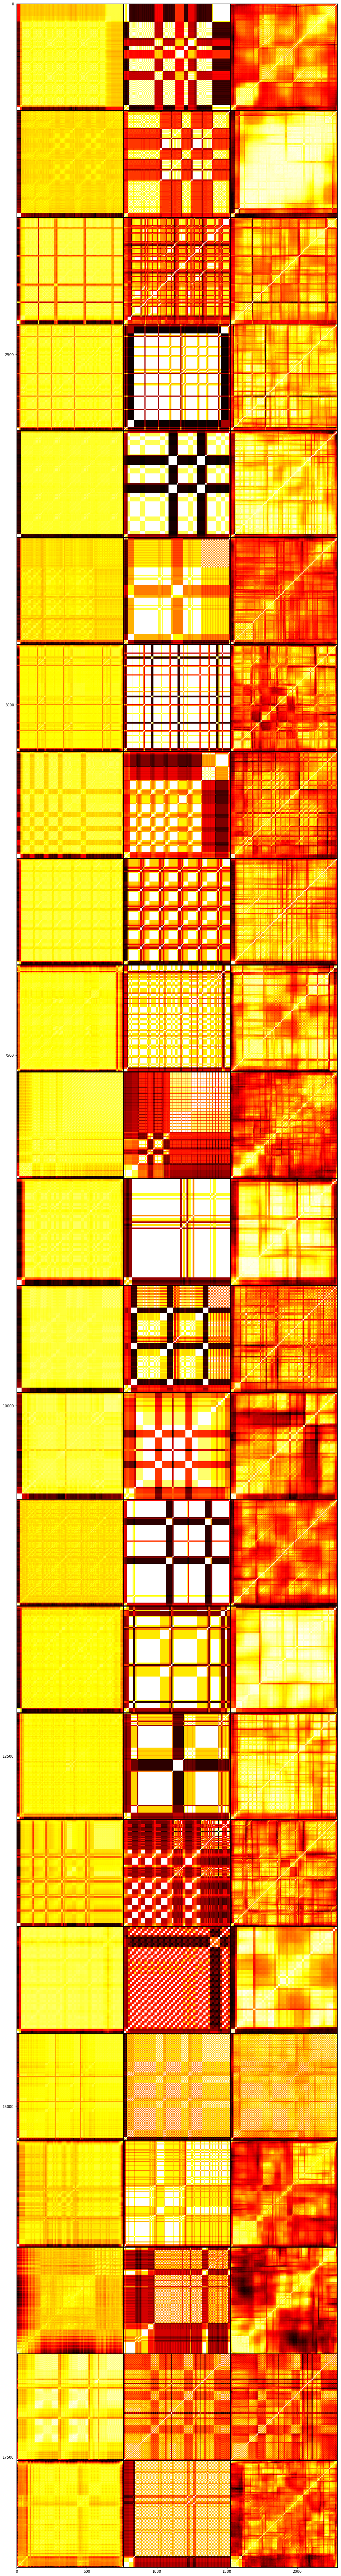

In [18]:
show_songs = total_test_files_num
#show_songs = 2

batch_idx = 0

batch_idx_list = list(range(total_test_files_num))

#np.random.shuffle(batch_idx_list)

song_idx_list = []
song_bars_num_list = []

# loop over songs to collect SSM data
for k, song_idx in enumerate(batch_idx_list[:show_songs]):

    # get song data
    cqt_trangle_ssm =    copy.copy(test_cqt_data_list[batch_idx][song_idx][:,:,0])
    drum_trangle_ssm =   copy.copy(test_drum_data_sample_gt_list[batch_idx][song_idx][:,:,0])
    drum_model_ssm =     copy.copy(test_drum_data_sample_list[batch_idx][song_idx][:,:,0])
    song_bars_num =      copy.copy(test_song_length_data_list[batch_idx][song_idx])

    cqt_restored_ssm =         resize_ssm_762(get_extracted_full_ssm(cqt_trangle_ssm, song_bars_num))
    drum_restored_ssm =        resize_ssm_762(get_extracted_full_ssm(drum_trangle_ssm, song_bars_num))
    drum_model_restored_ssm =  resize_ssm_762(get_extracted_triangle_ssm(drum_model_ssm, song_bars_num))

    cqt_drum_model_ssm = np.hstack([cqt_restored_ssm, 
                                    drum_restored_ssm, 
                                    drum_model_restored_ssm])
    
    if k==0:        
        cqt_drum_model_ssm_all = cqt_drum_model_ssm
        
    else:        
        cqt_drum_model_ssm_all = np.vstack([cqt_drum_model_ssm_all, 
                                            cqt_drum_model_ssm])


    song_idx_list.append(song_idx)
    song_bars_num_list.append(song_bars_num)

    
# show songs info
for k, song_idx in enumerate(test_song_length_data_list[0].tolist()[:show_songs]):
    print ('Song idx: {}, length: {}'.format(k, song_idx))

# plot actual song SSM
plt.figure(figsize=(8*2, 8*show_songs))
plt.imshow(cqt_drum_model_ssm_all, cmap='hot')
plt.show()

# check SSM extraction data

(256, 256)


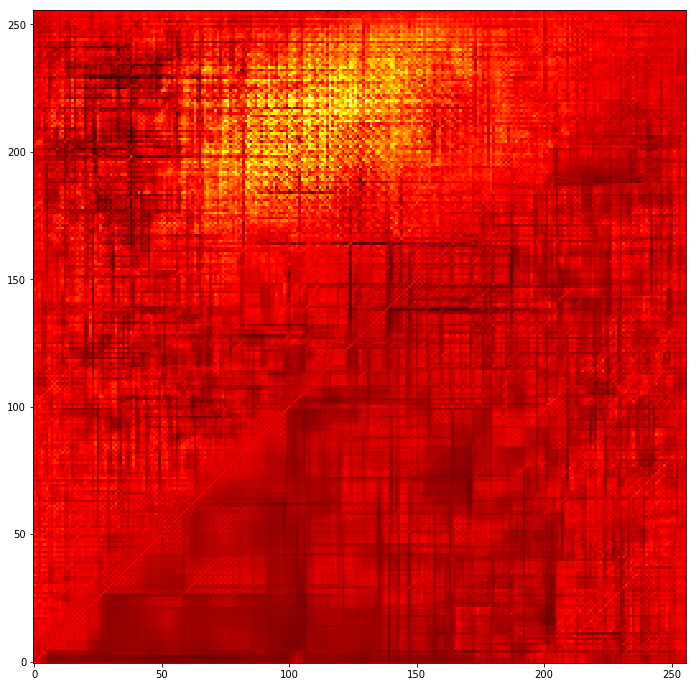

(101, 101)


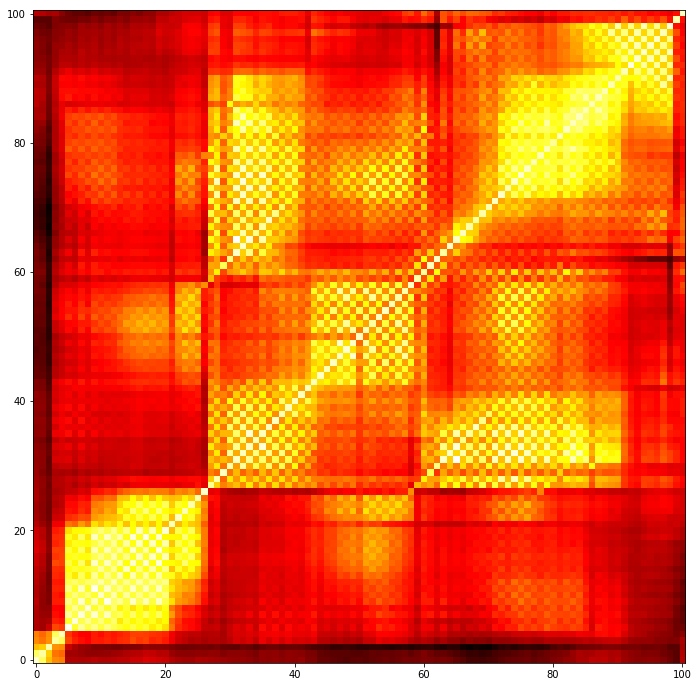

In [30]:
song_idx = 0
batch_idx = 0
drum_model_ssm =     copy.copy(test_drum_data_sample_list[batch_idx][song_idx][:,:,0])
song_bars_num =      copy.copy(test_song_length_data_list[batch_idx][song_idx])

print(drum_model_ssm.shape)
plt.figure(figsize=(12, 12))
plt.imshow(-drum_model_ssm, origin='lower', cmap='hot')
plt.show()

extracted_drum_ssm = get_extracted_triangle_ssm(drum_model_ssm, song_bars_num)
print (extracted_drum_ssm.shape)

plt.figure(figsize=(12, 12))
plt.imshow(-extracted_drum_ssm, origin='lower', cmap='hot')
plt.show()

# loop over files to save real song SSM

In [32]:
drum_ssm_list_for_save = []
n_bars_list_for_save = []

batch_idx = 0

for song_idx in range(0, total_test_files_num):
        
    drum_model_ssm = copy.copy(test_drum_data_sample_list[batch_idx][song_idx][:,:,0])
    
    song_bars_num = copy.copy(test_song_length_data_list[batch_idx][song_idx])
    
    extracted_drum_ssm = get_extracted_triangle_ssm(drum_model_ssm, song_bars_num)
    
    print ('Song: {}, Bars: {}, SSM shape: {}'.format(song_idx+1, song_bars_num, extracted_drum_ssm.shape))
    
    n_bars_list_for_save.append(song_bars_num)
    drum_ssm_list_for_save.append(extracted_drum_ssm)
    
print ('\n[conversion done]')
print (len(n_bars_list_for_save))
print (len(drum_ssm_list_for_save))

Song: 1, Bars: 101, SSM shape: (101, 101)
Song: 2, Bars: 82, SSM shape: (82, 82)
Song: 3, Bars: 91, SSM shape: (91, 91)
Song: 4, Bars: 94, SSM shape: (94, 94)
Song: 5, Bars: 86, SSM shape: (86, 86)
Song: 6, Bars: 84, SSM shape: (84, 84)
Song: 7, Bars: 101, SSM shape: (101, 101)
Song: 8, Bars: 91, SSM shape: (91, 91)
Song: 9, Bars: 88, SSM shape: (88, 88)
Song: 10, Bars: 79, SSM shape: (79, 79)
Song: 11, Bars: 140, SSM shape: (140, 140)
Song: 12, Bars: 68, SSM shape: (68, 68)
Song: 13, Bars: 74, SSM shape: (74, 74)
Song: 14, Bars: 62, SSM shape: (62, 62)
Song: 15, Bars: 109, SSM shape: (109, 109)
Song: 16, Bars: 68, SSM shape: (68, 68)
Song: 17, Bars: 111, SSM shape: (111, 111)
Song: 18, Bars: 95, SSM shape: (95, 95)
Song: 19, Bars: 52, SSM shape: (52, 52)
Song: 20, Bars: 118, SSM shape: (118, 118)
Song: 21, Bars: 141, SSM shape: (141, 141)
Song: 22, Bars: 133, SSM shape: (133, 133)
Song: 23, Bars: 100, SSM shape: (100, 100)
Song: 24, Bars: 146, SSM shape: (146, 146)

[conversion done]


# dump model output drum SSM prediction

In [33]:
merged_ssm_data = [n_bars_list_for_save,
                   drum_ssm_list_for_save]

save_ssm_pkl_file_name = './generation_evaluation_dir/model_out_drum_ssm_pkg.pkl'

with open(save_ssm_pkl_file_name, 'wb') as pkl_file:
    pickle.dump(merged_ssm_data, pkl_file)

# Restart IPython kernel after run all cell

In [ ]:
%%javascript
require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
                title: 'Notebook Halted',
                body: 'This notebook is no longer running; the kernel has been halted. Close the browser tab, or, to continue working, restart the kernel.',
                buttons: {
                    'Kernel restart': { click: function(){ Jupyter.notebook.session.restart(); } }
                }
        });
    }
);
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>